In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sb
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [2]:
import statsmodels.api as sm

In [3]:
long_df = pd.read_csv("oasis_longitudinal.csv")

In [4]:
long_df = long_df.drop("Subject ID",axis = 1)
long_df = long_df.drop("MRI ID",axis =1)
#dropping Hand column
long_df=long_df.drop("Hand",axis=1)
long_df.SES = long_df.SES.fillna(round(long_df.SES.mean()))
long_df.MMSE = long_df.MMSE.fillna(round(long_df.MMSE.mean()))
long_df['Group'] = long_df['Group'].replace('Converted','Demented') 
#creating dummy variables
long_df = pd.get_dummies(data= long_df,columns = {'Group','M/F'})
long_df = long_df.rename(columns={'M/F_F':'Female','M/F_M':'Male','Group_Demented':'Demented','Group_Nondemented':'Non-Demented'})
#Male=1 and Female=0
long_df=long_df.drop("Female",axis=1)
long_df = long_df.rename(columns={"Male":"Gender"})
#Demented=1 and Non-demented=0
long_df = long_df.drop("Non-Demented",axis=1)
long_df = long_df.rename(columns={"Demented":"Group"})

In [5]:
male_df = long_df[long_df['Gender']==1].drop("Gender",axis=1)
female_df = long_df[long_df['Gender']==0].drop("Gender",axis=1)

In [6]:
columns =['Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF']

In [7]:
X_train_male = male_df[['Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF']].to_numpy()
Y_train_male = male_df['Group'].to_numpy()
X_train_female = female_df[['Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF']].to_numpy()
Y_train_female = female_df['Group'].to_numpy()
X_train = long_df[['Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF']].to_numpy()
Y_train = long_df['Group'].to_numpy()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [9]:
def scale(X):
    scaler = MinMaxScaler().fit(X)
    X=scaler.transform(X)
    return X

In [10]:
X_train = scale(X_train)
X_train_male = scale(X_train_male)
X_train_female = scale(X_train_female)

In [11]:
performance = [['Model','Trained on Type of data','Predicting data','Accuracy in %','Sensitivity','Specificity']]
factors =[]

In [12]:
def plt_confusion_matrix(Y,Y_predicted,title='Confusion Matrix'):
    cf = confusion_matrix(Y, Y_predicted)
    df_cm = pd.DataFrame(cf,columns=['Non-demented','Demented'],index=['Non-demented','Demented'])
    sb.heatmap(df_cm,annot=True,fmt='g',cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

## Logistic Regression for entire data

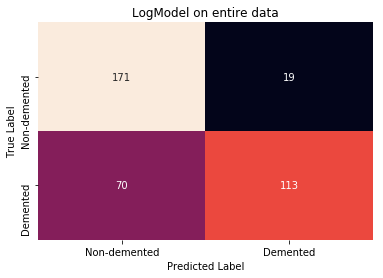

In [13]:
LogModel= LogisticRegression(solver='lbfgs').fit(X_train,Y_train)
Y_predicted = LogModel.predict(X_train)
acc = accuracy_score(Y_train,Y_predicted)
plt_confusion_matrix(Y_train,Y_predicted,title='LogModel on entire data')
plt.savefig('LogModel on entire data.png')
cf = confusion_matrix(Y_train, Y_predicted)
tn, fp, fn, tp = cf.ravel()
sensitivity= tp/(tp+fn)
specificity = tn/(tn+fp)
performance.append(['Logistic Regression','Entire dataset','Entire dataset',acc*100,sensitivity,specificity])

In [14]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns]).T, LogModel.coef_.T)), 
                                columns=['feature', 'importance'])
feature_importance

,feature,importance
0,Age,-1.008469234509097
1,EDUC,-1.6925291464278163
2,SES,-0.6377484693032185
3,MMSE,-5.140264311683276
4,eTIV,-0.4395529820038815
5,nWBV,-2.4579721305173616
6,ASF,0.23678537631624488


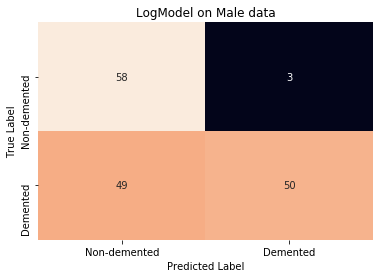

In [15]:
#predicting on male data
Y_predicted_male = LogModel.predict(X_train_male)
acc = accuracy_score(Y_train_male,Y_predicted_male)
plt_confusion_matrix(Y_train_male,Y_predicted_male,title='LogModel on Male data')
plt.savefig('LogModel on Male data.png')
cf = confusion_matrix(Y_train_male, Y_predicted_male)
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity= tp/(tp+fn)
specificity = tn/(tn+fp)
performance.append(['Logistic Regression','Entire dataset','Male dataset',acc*100,sensitivity,specificity])

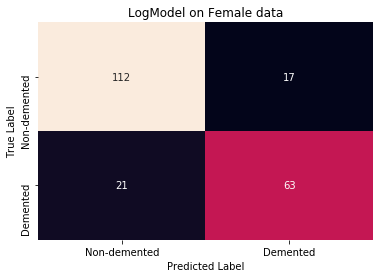

In [16]:
#predicting on female data
Y_predicted_female = LogModel.predict(X_train_female)
acc = accuracy_score(Y_train_female,Y_predicted_female)
plt_confusion_matrix(Y_train_female,Y_predicted_female,title='LogModel on Female data')
plt.savefig('LogModel on Female data.png')
cf = confusion_matrix(Y_train_female, Y_predicted_female)
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity= tp/(tp+fn)
specificity = tn/(tn+fp)
performance.append(['Logistic Regression','Entire dataset','Female dataset',acc*100,sensitivity,specificity])

## Important Features for LogModel

In [17]:
print('Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF')
rfe = RFE(LogModel, 4)
fit = rfe.fit(X_train, Y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Age EDUC SES MMSE eTIV nWBV ASF
Num Features: 4
Selected Features: [ True  True False  True False  True False]
Feature Ranking: [1 1 2 1 3 1 4]


In [18]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns]).T, LogModel.coef_.T)), 
                                columns=['feature', 'importance'])
feature_importance

,feature,importance
0,Age,-1.008469234509097
1,EDUC,-1.6925291464278163
2,SES,-0.6377484693032185
3,MMSE,-5.140264311683276
4,eTIV,-0.4395529820038815
5,nWBV,-2.4579721305173616
6,ASF,0.23678537631624488


## Logistic Regression for male data

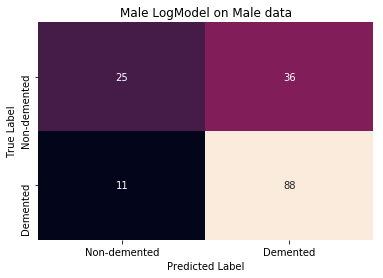

In [19]:
LogModel_m = LogisticRegression(solver='lbfgs').fit(X_train_male,Y_train_male)
Y_predicted_male = LogModel_m.predict(X_train_male)
acc = accuracy_score(Y_train_male,Y_predicted_male)
plt_confusion_matrix(Y_train_male,Y_predicted_male,title='Male LogModel on Male data')
plt.savefig('Male LogModel on Male data.png')
cf = confusion_matrix(Y_train_male, Y_predicted_male)
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
performance.append(['Logistic Regression(Male)','Male dataset','Male dataset',acc*100,sensitivity,specificity])

## Important features for Male LogModel

In [20]:
print('Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF')
rfe = RFE(LogModel_m, 4)
fit = rfe.fit(X_train_male, Y_train_male)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Age EDUC SES MMSE eTIV nWBV ASF
Num Features: 4
Selected Features: [False False False  True  True  True  True]
Feature Ranking: [4 3 2 1 1 1 1]


In [21]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns]).T, LogModel_m.coef_.T)), 
                                columns=['feature', 'importance'])
feature_importance

,feature,importance
0,Age,-0.19423471488830757
1,EDUC,-0.23080090674634365
2,SES,-0.8142024644025381
3,MMSE,-2.786935078869488
4,eTIV,-1.206297412841878
5,nWBV,-1.5778821594302155
6,ASF,1.2920301328644277


## Comparing ROC curves on male data by LogModel and LogModel_m

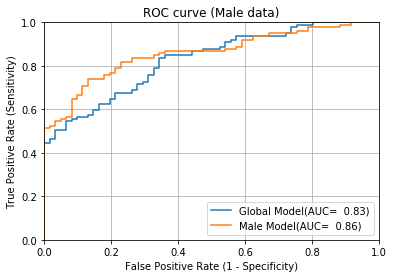

In [22]:
#predicting probabilities of the predicted class
y_pred_prob = LogModel.predict_proba(X_train_male)[:,1]
y_pred_prob_male = LogModel_m.predict_proba(X_train_male)[:,1]
#Plotting ROC curve
fpr, tpr, _ = roc_curve(Y_train_male, y_pred_prob)
fpr_m, tpr_m, _ = roc_curve(Y_train_male, y_pred_prob_male)
AUC = auc(fpr,tpr)
AUC_m = auc(fpr_m,tpr_m)
plt.plot(fpr, tpr,label='Global Model(AUC= % 0.2f)' % AUC)
plt.plot(fpr_m, tpr_m,label='Male Model(AUC= % 0.2f)' % AUC_m)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve (Male data)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC curve(Male data).png')

## Logistic Regression for female data

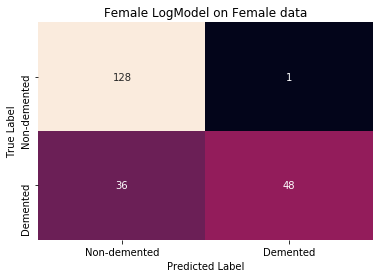

In [23]:
LogModel_f = LogisticRegression(solver='lbfgs').fit(X_train_female,Y_train_female)
Y_predicted_female = LogModel_f.predict(X_train_female)
acc = accuracy_score(Y_train_female,Y_predicted_female)
plt_confusion_matrix(Y_train_female,Y_predicted_female,title='Female LogModel on Female data')
plt.savefig('Female LogModel on Female data.png')
cf = confusion_matrix(Y_train_female, Y_predicted_female)
tn = cf[0][0]
fp = cf[0][1]
fn = cf[1][0]
tp = cf[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
performance.append(['Logistic Regression(Female)','Female dataset','Female dataset',acc*100,sensitivity,specificity])

## Important features for Female Log Model

In [24]:
print('Age', 'EDUC', 'SES', 'MMSE', 'eTIV',
       'nWBV', 'ASF')
rfe = RFE(LogModel, 4)
fit = rfe.fit(X_train_female, Y_train_female)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Age EDUC SES MMSE eTIV nWBV ASF
Num Features: 4
Selected Features: [False  True False  True  True  True False]
Feature Ranking: [2 1 3 1 1 1 4]


In [25]:
feature_importance=pd.DataFrame(np.hstack((np.array([columns]).T, LogModel_f.coef_.T)), 
                                columns=['feature', 'importance'])
feature_importance

,feature,importance
0,Age,-0.6438610829582669
1,EDUC,-2.162286344139639
2,SES,-0.47169043935956917
3,MMSE,-4.14434028526847
4,eTIV,-0.6691565402510162
5,nWBV,-1.5037351560187764
6,ASF,0.4612677208934475


## Comparing ROC curves on female data by LogModel and LogModel_f

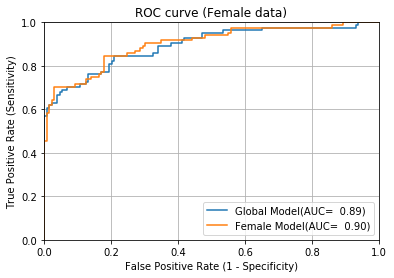

In [26]:
#predicting probabilities of the predicted class
y_pred_prob = LogModel.predict_proba(X_train_female)[:,1]
y_pred_prob_f = LogModel_f.predict_proba(X_train_female)[:,1]
#Plotting ROC curve
fpr, tpr, _ = roc_curve(Y_train_female, y_pred_prob)
fpr_f, tpr_f, _ = roc_curve(Y_train_female, y_pred_prob_f)
AUC = auc(fpr,tpr)
AUC_f = auc(fpr_f,tpr_f)
plt.plot(fpr, tpr,label='Global Model(AUC= % 0.2f)' % AUC)
plt.plot(fpr_f, tpr_f,label='Female Model(AUC= % 0.2f)' % AUC_f)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve (Female data)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('ROC curve(Female data).png')

In [27]:
performance

[['Model',
  'Trained on Type of data',
  'Predicting data',
  'Accuracy in %',
  'Sensitivity',
  'Specificity'],
 ['Logistic Regression',
  'Entire dataset',
  'Entire dataset',
  76.13941018766755,
  0.6174863387978142,
  0.9],
 ['Logistic Regression',
  'Entire dataset',
  'Male dataset',
  67.5,
  0.5050505050505051,
  0.9508196721311475],
 ['Logistic Regression',
  'Entire dataset',
  'Female dataset',
  82.15962441314554,
  0.75,
  0.8682170542635659],
 ['Logistic Regression(Male)',
  'Male dataset',
  'Male dataset',
  70.625,
  0.8888888888888888,
  0.4098360655737705],
 ['Logistic Regression(Female)',
  'Female dataset',
  'Female dataset',
  82.62910798122066,
  0.5714285714285714,
  0.9922480620155039]]

In [28]:
import csv
with open('Performance.csv', 'w', newline='') as myfile:
    for entries in performance:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(entries)
        wr.writerow("\n")